In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import h5py
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset for Galaxy10
def load_galaxy10_data():
    with h5py.File("Galaxy10.h5", "r") as f:
        images = np.array(f["images"])  # Shape: (N, H, W, C)
        labels = np.array(f["ans"])  # Shape: (N,)
    return images, labels

class Galaxy10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to PIL Image (Ensure 3 channels)
        image = Image.fromarray(image[:, :, :3])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Dataset
images, labels = load_galaxy10_data()
dataset = Galaxy10Dataset(images, labels, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define CvT Model
class CvT(nn.Module):
    def __init__(self, num_classes=10):
        super(CvT, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(256 * 28 * 28, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize Model, Loss, Optimizer
model = CvT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Training Loop with Early Stopping and tqdm
num_epochs = 50
early_stopping_patience = 5
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
    
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Early Stopping Check
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

print("Training complete!")

# Testing Loop
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=3))


Epoch 1/50: 100%|██████████| 273/273 [00:30<00:00,  8.90it/s, accuracy=41.6, loss=1.19]


Epoch 1/50, Loss: 1.4623, Accuracy: 41.57%


Epoch 2/50: 100%|██████████| 273/273 [00:30<00:00,  9.03it/s, accuracy=49.5, loss=1.11] 


Epoch 2/50, Loss: 1.2314, Accuracy: 49.52%


Epoch 3/50: 100%|██████████| 273/273 [00:30<00:00,  8.93it/s, accuracy=53, loss=1.34]   


Epoch 3/50, Loss: 1.1555, Accuracy: 52.96%


Epoch 4/50: 100%|██████████| 273/273 [00:30<00:00,  8.85it/s, accuracy=54.4, loss=0.552]


Epoch 4/50, Loss: 1.1097, Accuracy: 54.44%


Epoch 5/50: 100%|██████████| 273/273 [00:30<00:00,  8.86it/s, accuracy=56.1, loss=1.31] 


Epoch 5/50, Loss: 1.0688, Accuracy: 56.05%


Epoch 6/50: 100%|██████████| 273/273 [00:30<00:00,  8.91it/s, accuracy=58.1, loss=0.783]


Epoch 6/50, Loss: 1.0279, Accuracy: 58.14%


Epoch 7/50: 100%|██████████| 273/273 [00:33<00:00,  8.23it/s, accuracy=59.7, loss=1.32] 


Epoch 7/50, Loss: 0.9934, Accuracy: 59.67%


Epoch 8/50: 100%|██████████| 273/273 [00:30<00:00,  8.88it/s, accuracy=61.1, loss=1.18] 


Epoch 8/50, Loss: 0.9594, Accuracy: 61.14%


Epoch 9/50: 100%|██████████| 273/273 [00:30<00:00,  8.90it/s, accuracy=62.8, loss=0.563]


Epoch 9/50, Loss: 0.9276, Accuracy: 62.84%


Epoch 10/50: 100%|██████████| 273/273 [00:30<00:00,  8.92it/s, accuracy=65, loss=0.589]  


Epoch 10/50, Loss: 0.8857, Accuracy: 64.96%


Epoch 11/50: 100%|██████████| 273/273 [00:30<00:00,  8.92it/s, accuracy=67, loss=0.551]  


Epoch 11/50, Loss: 0.8520, Accuracy: 66.99%


Epoch 12/50: 100%|██████████| 273/273 [00:30<00:00,  8.83it/s, accuracy=69.3, loss=0.721]


Epoch 12/50, Loss: 0.8141, Accuracy: 69.31%


Epoch 13/50: 100%|██████████| 273/273 [00:30<00:00,  8.86it/s, accuracy=70, loss=0.729]  


Epoch 13/50, Loss: 0.7915, Accuracy: 70.01%


Epoch 14/50: 100%|██████████| 273/273 [00:30<00:00,  8.94it/s, accuracy=71.8, loss=1.14] 


Epoch 14/50, Loss: 0.7533, Accuracy: 71.79%


Epoch 15/50: 100%|██████████| 273/273 [00:30<00:00,  8.90it/s, accuracy=73.3, loss=0.664]


Epoch 15/50, Loss: 0.7285, Accuracy: 73.28%


Epoch 16/50: 100%|██████████| 273/273 [00:30<00:00,  8.93it/s, accuracy=74.6, loss=0.613]


Epoch 16/50, Loss: 0.7021, Accuracy: 74.59%


Epoch 17/50: 100%|██████████| 273/273 [00:30<00:00,  8.89it/s, accuracy=75.5, loss=0.396]


Epoch 17/50, Loss: 0.6783, Accuracy: 75.53%


Epoch 18/50: 100%|██████████| 273/273 [00:30<00:00,  8.95it/s, accuracy=76, loss=0.705]  


Epoch 18/50, Loss: 0.6628, Accuracy: 76.00%


Epoch 19/50: 100%|██████████| 273/273 [00:30<00:00,  8.96it/s, accuracy=77.2, loss=1.09] 


Epoch 19/50, Loss: 0.6353, Accuracy: 77.24%


Epoch 20/50: 100%|██████████| 273/273 [00:30<00:00,  8.90it/s, accuracy=77.5, loss=0.646]


Epoch 20/50, Loss: 0.6190, Accuracy: 77.47%


Epoch 21/50: 100%|██████████| 273/273 [00:30<00:00,  8.83it/s, accuracy=78.3, loss=0.471]


Epoch 21/50, Loss: 0.5991, Accuracy: 78.31%


Epoch 22/50: 100%|██████████| 273/273 [00:30<00:00,  8.96it/s, accuracy=78.7, loss=0.458]


Epoch 22/50, Loss: 0.5890, Accuracy: 78.72%


Epoch 23/50: 100%|██████████| 273/273 [00:30<00:00,  8.95it/s, accuracy=79.5, loss=0.645]


Epoch 23/50, Loss: 0.5696, Accuracy: 79.53%


Epoch 24/50: 100%|██████████| 273/273 [00:30<00:00,  8.88it/s, accuracy=79.7, loss=0.525]


Epoch 24/50, Loss: 0.5629, Accuracy: 79.65%


Epoch 25/50: 100%|██████████| 273/273 [00:30<00:00,  8.93it/s, accuracy=80.4, loss=0.296]


Epoch 25/50, Loss: 0.5407, Accuracy: 80.45%


Epoch 26/50: 100%|██████████| 273/273 [00:30<00:00,  8.92it/s, accuracy=80.2, loss=0.213]


Epoch 26/50, Loss: 0.5462, Accuracy: 80.16%


Epoch 27/50: 100%|██████████| 273/273 [00:30<00:00,  8.96it/s, accuracy=80.8, loss=0.578]


Epoch 27/50, Loss: 0.5258, Accuracy: 80.84%


Epoch 28/50: 100%|██████████| 273/273 [00:30<00:00,  8.81it/s, accuracy=81.9, loss=0.4]  


Epoch 28/50, Loss: 0.5073, Accuracy: 81.86%


Epoch 29/50: 100%|██████████| 273/273 [00:30<00:00,  8.92it/s, accuracy=81.1, loss=0.557]


Epoch 29/50, Loss: 0.5138, Accuracy: 81.12%


Epoch 30/50: 100%|██████████| 273/273 [00:30<00:00,  8.94it/s, accuracy=81.9, loss=0.865]


Epoch 30/50, Loss: 0.4978, Accuracy: 81.95%


Epoch 31/50: 100%|██████████| 273/273 [00:30<00:00,  8.90it/s, accuracy=82.2, loss=0.343]


Epoch 31/50, Loss: 0.4900, Accuracy: 82.22%


Epoch 32/50: 100%|██████████| 273/273 [00:30<00:00,  8.91it/s, accuracy=82.4, loss=0.571]


Epoch 32/50, Loss: 0.4846, Accuracy: 82.42%


Epoch 33/50: 100%|██████████| 273/273 [00:30<00:00,  8.93it/s, accuracy=82.9, loss=0.311]


Epoch 33/50, Loss: 0.4719, Accuracy: 82.88%


Epoch 34/50: 100%|██████████| 273/273 [00:30<00:00,  8.94it/s, accuracy=83.9, loss=0.197]


Epoch 34/50, Loss: 0.4501, Accuracy: 83.90%


Epoch 35/50: 100%|██████████| 273/273 [00:30<00:00,  8.97it/s, accuracy=83.5, loss=0.494]


Epoch 35/50, Loss: 0.4579, Accuracy: 83.49%


Epoch 36/50: 100%|██████████| 273/273 [00:30<00:00,  8.82it/s, accuracy=83.5, loss=0.517]


Epoch 36/50, Loss: 0.4570, Accuracy: 83.52%


Epoch 37/50: 100%|██████████| 273/273 [00:30<00:00,  8.89it/s, accuracy=84.4, loss=0.404]


Epoch 37/50, Loss: 0.4362, Accuracy: 84.43%


Epoch 38/50: 100%|██████████| 273/273 [00:30<00:00,  8.94it/s, accuracy=84.2, loss=0.23] 


Epoch 38/50, Loss: 0.4383, Accuracy: 84.23%


Epoch 39/50: 100%|██████████| 273/273 [00:30<00:00,  8.93it/s, accuracy=84.6, loss=0.36] 


Epoch 39/50, Loss: 0.4276, Accuracy: 84.65%


Epoch 40/50: 100%|██████████| 273/273 [00:30<00:00,  8.90it/s, accuracy=84.8, loss=0.852]


Epoch 40/50, Loss: 0.4243, Accuracy: 84.80%


Epoch 41/50: 100%|██████████| 273/273 [00:30<00:00,  8.95it/s, accuracy=84.5, loss=0.395]


Epoch 41/50, Loss: 0.4257, Accuracy: 84.52%


Epoch 42/50: 100%|██████████| 273/273 [00:30<00:00,  8.96it/s, accuracy=85.5, loss=0.535]


Epoch 42/50, Loss: 0.4077, Accuracy: 85.52%


Epoch 43/50: 100%|██████████| 273/273 [00:30<00:00,  8.89it/s, accuracy=85.8, loss=0.124]


Epoch 43/50, Loss: 0.3966, Accuracy: 85.80%


Epoch 44/50: 100%|██████████| 273/273 [00:30<00:00,  8.85it/s, accuracy=85.6, loss=0.258]


Epoch 44/50, Loss: 0.4004, Accuracy: 85.62%


Epoch 45/50: 100%|██████████| 273/273 [00:30<00:00,  8.93it/s, accuracy=85.8, loss=0.288]


Epoch 45/50, Loss: 0.3981, Accuracy: 85.83%


Epoch 46/50: 100%|██████████| 273/273 [00:30<00:00,  8.97it/s, accuracy=86.6, loss=0.229]


Epoch 46/50, Loss: 0.3753, Accuracy: 86.60%


Epoch 47/50: 100%|██████████| 273/273 [00:30<00:00,  8.93it/s, accuracy=86.7, loss=0.321]


Epoch 47/50, Loss: 0.3757, Accuracy: 86.67%


Epoch 48/50: 100%|██████████| 273/273 [00:30<00:00,  8.92it/s, accuracy=86.4, loss=0.242]


Epoch 48/50, Loss: 0.3804, Accuracy: 86.40%


Epoch 49/50: 100%|██████████| 273/273 [00:30<00:00,  8.95it/s, accuracy=86.8, loss=0.62] 


Epoch 49/50, Loss: 0.3645, Accuracy: 86.79%


Epoch 50/50: 100%|██████████| 273/273 [00:30<00:00,  8.96it/s, accuracy=86.5, loss=0.432]


Epoch 50/50, Loss: 0.3744, Accuracy: 86.54%
Training complete!
Test Accuracy: 78.01%
Classification Report:
              precision    recall  f1-score   support

           0      0.601     0.559     0.579       641
           1      0.886     0.904     0.895      1421
           2      0.795     0.906     0.846      1281
           3      0.653     0.471     0.547        68
           4      0.848     0.868     0.858       303
           5      0.000     0.000     0.000         4
           6      0.745     0.752     0.749       101
           7      0.659     0.565     0.608       246
           8      0.488     0.330     0.394       191
           9      0.479     0.228     0.309       101

    accuracy                          0.780      4357
   macro avg      0.615     0.558     0.579      4357
weighted avg      0.767     0.780     0.770      4357



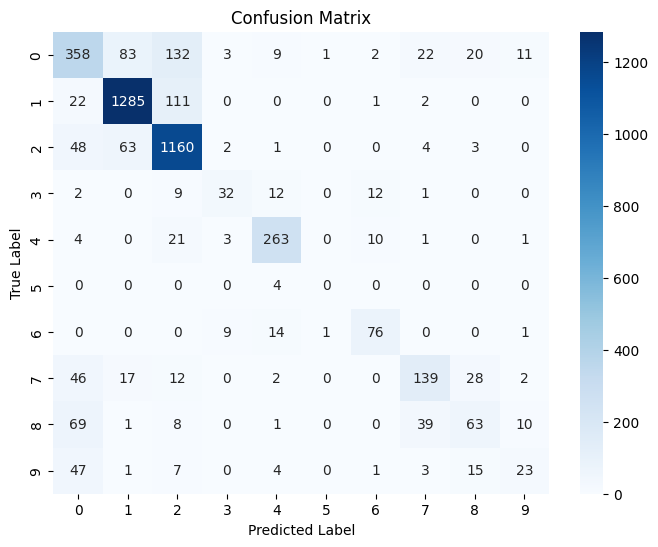

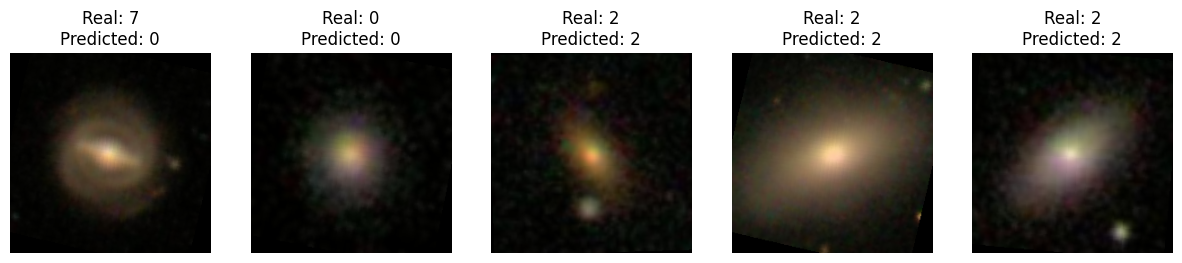

In [5]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Visualizing 5 Galaxy Images with Real and Classified Labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
sample_indices = np.random.choice(len(test_dataset), 5, replace=False)

for i, idx in enumerate(sample_indices):
    image, label = test_dataset[idx]
    image_np = image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # Denormalize
    pred_label = all_preds[idx]
    
    axes[i].imshow(image_np)
    axes[i].set_title(f"Real: {label}\nPredicted: {pred_label}")
    axes[i].axis("off")

plt.show()
